<a href="https://colab.research.google.com/github/kennedyf2r/mvp_sprint_3/blob/main/MVP_Sprint_3_Kennedy_Ribeiro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MVP Engenharia de Dados - PUC RIO - Sprint 3
##Profs. Tatiana Escovedo e Hélio Lopes
###Aluno: Francisco Kennedy Ribeiro da Rocha

# **Objetivo do MVP**

Construir um pipeline de dados utilizando tecnologias na nuvem. O pipeline irá envolver a busca, coleta, modelagem, carga e análise dos dados.



#**Descrição do Problema**

A partir de dados sobre transações de vendas on-line em diferentes categorias de produtos, tenho o objetivo de responder os seguintes questionamentos:

1 - Qual é o impacto dos métodos de pagamento no volume de vendas e na receita?

Motivação: Entender se certos métodos de pagamento incentivam mais compras pode ajudar a ajustar estratégias de marketing e políticas de pagamento.

2 - Quais são os produtos mais vendidos em cada categoria e como eles contribuem para a receita total da categoria?

Motivação: Identificar os produtos mais populares pode ajudar a otimizar o estoque e direcionar campanhas de marketing para produtos de maior sucesso.

# **Sobre a Base de Dados**

Escolhi um conjunto de dados chamado "Online Sales Dataset".

Este conjunto de dados fornece uma visão geral abrangente das transações de vendas on-line em diferentes categorias de produtos. Cada linha representa uma única transação com informações detalhadas, como ID do pedido, data, categoria, nome do produto, quantidade vendida, preço unitário, preço total, região e método de pagamento.

Colunas do Dataset:

- Order ID: Identificador exclusivo para cada pedido de venda.

- Date: Data da transação de venda.

- Category: Categoria ampla do produto vendido (por exemplo, eletrônicos, eletrodomésticos, roupas, livros, produtos de beleza, esportes).

- Product Name: Nome ou modelo específico do produto vendido.

- Quantity: Número de unidades do produto vendidas na transação.

- Unit Price: Preço de uma unidade do produto.

- Total Price: Receita total gerada pela transação de vendas (Quantidade * Preço unitário).

- Region: Região geográfica onde a transação ocorreu (por exemplo, América do Norte, Europa, Ásia).

- Payment Method: Método usado para pagamento (por exemplo, cartão de crédito, PayPal, cartão de débito).

Inicialmente, a base de dados estava disponível no meu Git Hub, por meio do seguinte link:

https://raw.githubusercontent.com/kennedyf2r/mvp_sprint_3/main/online_sales%20_data.csv

A partir de então, iniciei as etapas do pipeline de dados.



# **Plataforma de Nuvem Escolhida**

Para execução do trabalho, utilizei soluções disponíveis no ambiente de nuvem da AWS.

# **Passo 1: Configuração do Datalake**

O primeiro passo realizado foi estruturação do datalake, criando buckets no AWS S3.

O meu datalake foi estruturado em camadas: Bronze, Silver e Gold.

A camada bronze contém os dados originais, sem nenhum tratamento.

Na camada Silver é realizado um tratamento inicial sobre os dados da camada bronze.

A na camada Gold constam os dados refinados, prontos para serem disponibilizados para análise e visualização.



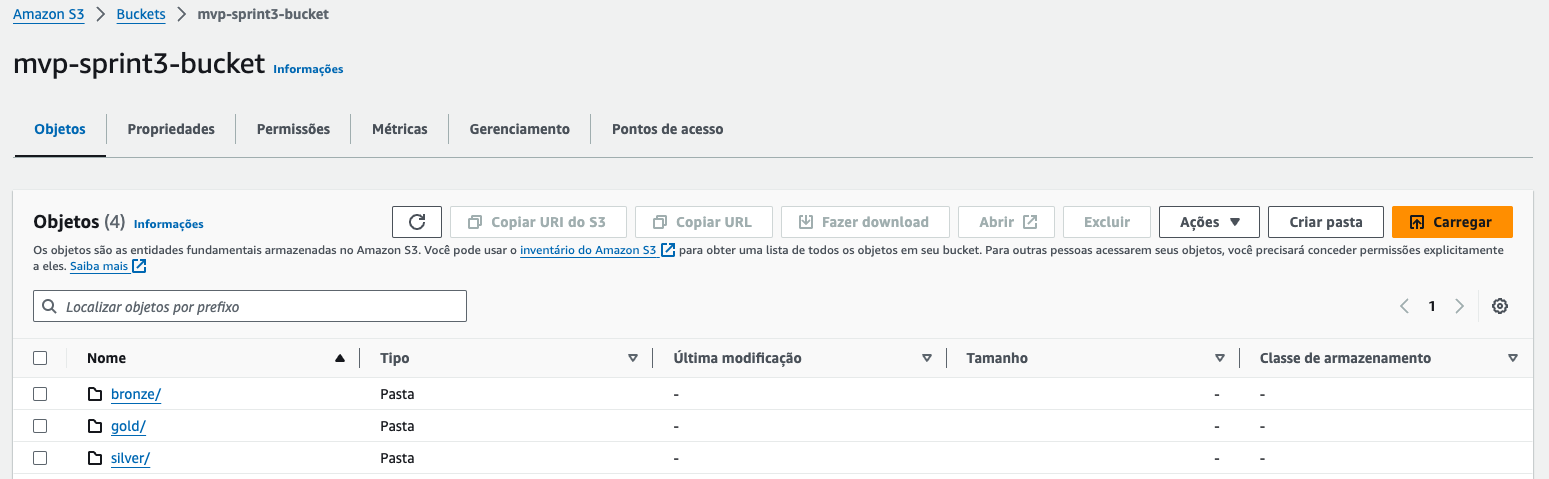

#**Passo 2 - Ingestão dos Dados**

Neste segundo passo do meu projeto MVP, estou trazendo dados de vendas online armazenados no GitHub para o meu data lake na AWS.

O que o código faz:

- Configuração: Inicializo os contextos do Spark e do Glue.
- Download: Baixo o arquivo CSV de vendas do meu repositório no GitHub.
- Leitura: Leio o arquivo CSV usando pandas.
- Conversão: Converto o DataFrame do pandas para um DataFrame do Spark.
- Armazenamento: Salvo os dados no bucket S3 mvp-sprint3-bucket na pasta bronze.
- Finalização: Comito o job para finalizar a execução.

Resumo Pessoal:

Com esse código, estou iniciando a construção do meu data lake, importando dados brutos de vendas para a área bronze no S3, preparando o terreno para as próximas etapas de transformação e análise.



In [ ]:
import sys
import boto3
import requests
from awsglue.transforms import *
from awsglue.utils import getResolvedOptions
from pyspark.context import SparkContext
from awsglue.context import GlueContext
from awsglue.job import Job
import pandas as pd

# Parâmetros do job
args = getResolvedOptions(sys.argv, ['JOB_NAME'])
sc = SparkContext()
glueContext = GlueContext(sc)
spark = glueContext.spark_session
job = Job(glueContext)
job.init(args['JOB_NAME'], args)

# URL do GitHub
url = "https://raw.githubusercontent.com/kennedyf2r/mvp_sprint_3/main/online_sales%20_data.csv"

# Baixar o arquivo do GitHub
response = requests.get(url)
open('/tmp/online_sales_data.csv', 'wb').write(response.content)

# Ler o arquivo CSV
df = pd.read_csv('/tmp/online_sales_data.csv')

# Criar um Spark DataFrame
spark_df = spark.createDataFrame(df)

# Salvar o DataFrame na área bronze do S3
s3_path = "s3://mvp-sprint3-bucket/bronze/online_sales_data.csv"
spark_df.write.mode('overwrite').csv(s3_path, header=True)

job.commit()


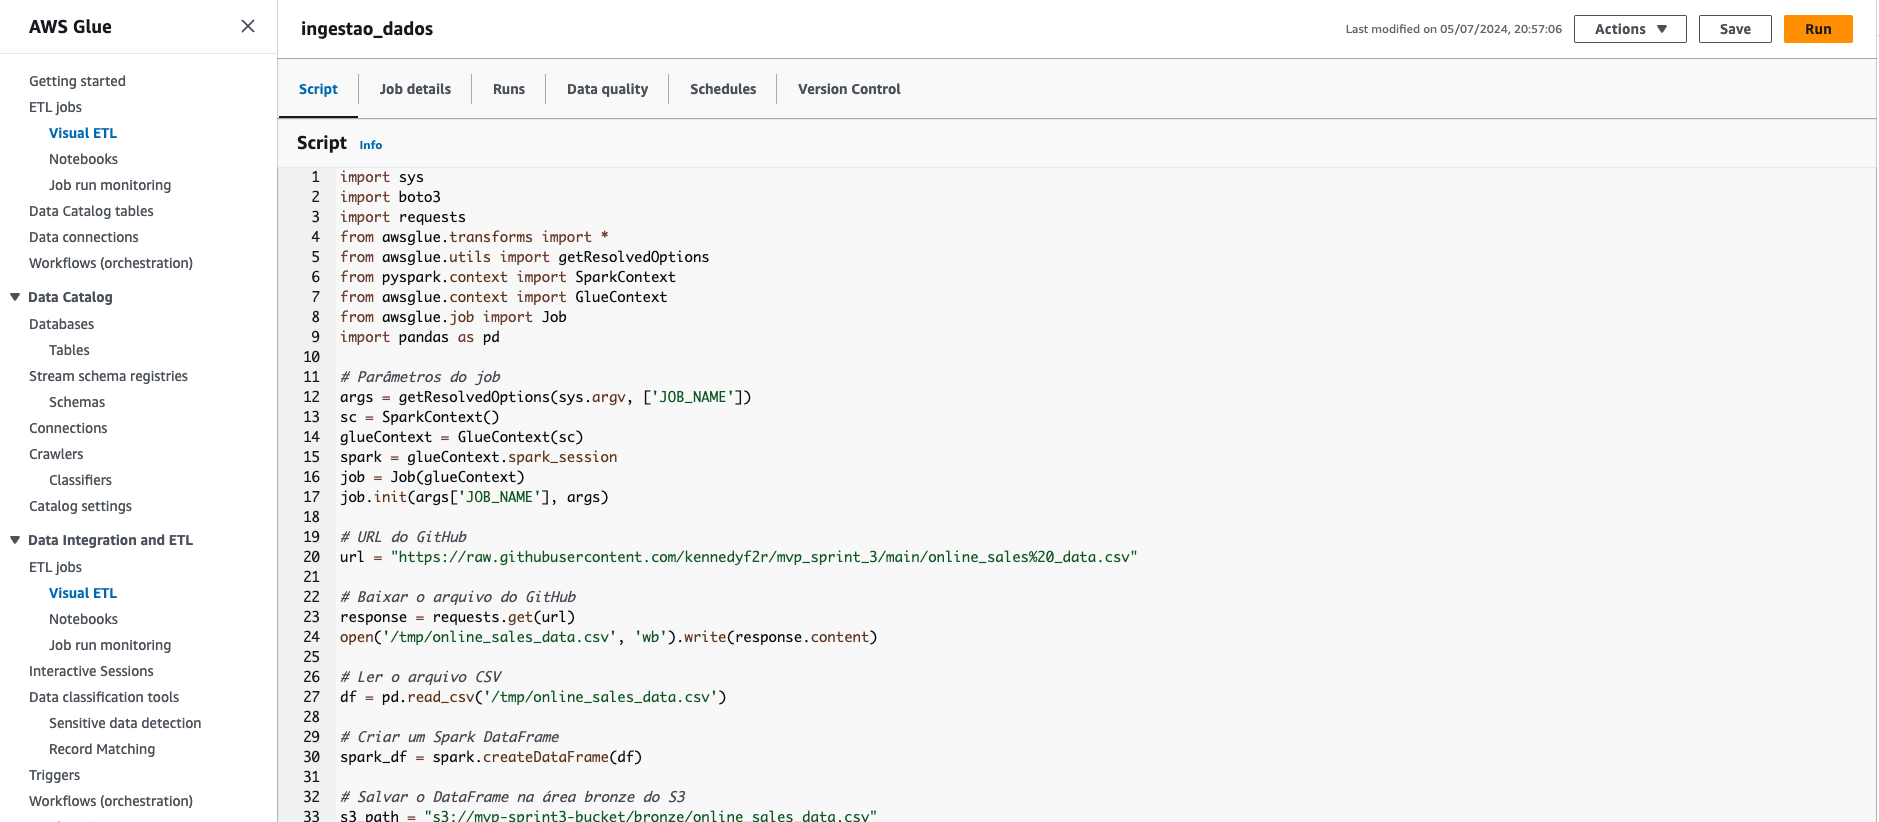

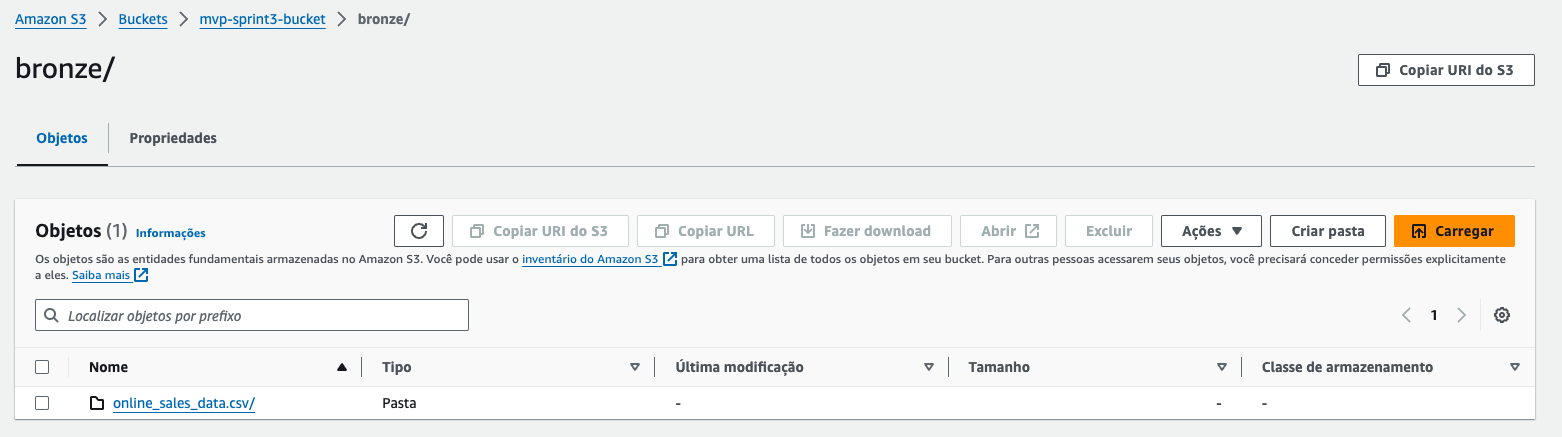

#**Passo 2 - Tratamento dos dados (Camada Silver)**

Neste código específico para a camada Silver, estou realizando uma série de operações essenciais para garantir a qualidade e a integridade dos dados:

- Carregamento dos Dados: Primeiro, importo os dados brutos da camada Bronze, que estão armazenados no Amazon S3. Esses dados são lidos em um DataFrame do Spark para manipulação.

- Remoção de Duplicatas: Utilizo o método dropDuplicates() para eliminar quaisquer registros duplicados que possam existir no conjunto de dados. Isso é crucial para garantir que cada entrada seja única e não introduza distorções nos resultados analíticos subsequentes.

- Conversão de Tipos de Dados: Ajusto os tipos de dados das colunas conforme necessário. Por exemplo, a coluna "Date" é convertida para o tipo date, enquanto "Units Sold" é convertida para integer e "Unit Price" e "Total Revenue" são convertidas para float. Essa etapa é crucial para garantir que os cálculos subsequentes sejam precisos e eficientes.

- Tratamento de Valores Nulos: Realizo a limpeza de dados removendo linhas que contenham valores nulos em qualquer coluna. Isso é feito utilizando na.drop(), o que ajuda a garantir que apenas dados completos e válidos sejam considerados nas análises posteriores.

- Padronização de Formatos: Para consistência e facilitar a análise, transformo todas as entradas da coluna "Region" para letras maiúsculas usando upper(). Isso evita discrepâncias devido a diferentes formas de entrada dos dados.

- Filtragem de Dados Inválidos: Aplico filtros para garantir a integridade dos dados relacionados às vendas. Por exemplo, verifico se as unidades vendidas e a receita total são consistentes com o preço unitário informado, utilizando condições como (col("Units Sold") > 0) e (col("Total Revenue") == col("Units Sold") * col("Unit Price")). Essa validação ajuda a identificar e corrigir possíveis erros nos dados de vendas.

- Persistência na Camada Silver: Finalmente, os dados processados e validados são salvos na camada Silver do Amazon S3 no formato Parquet. Este formato é eficiente em termos de armazenamento e é ideal para consultas analíticas subsequentes.

Essas etapas são fundamentais para preparar os dados para análises mais profundas e para garantir que as decisões baseadas nesses dados sejam confiáveis e precisas.

In [ ]:
import sys
from awsglue.transforms import *
from awsglue.utils import getResolvedOptions
from pyspark.context import SparkContext
from awsglue.context import GlueContext
from awsglue.job import Job
from pyspark.sql.functions import col, upper

# Parâmetros do job
args = getResolvedOptions(sys.argv, ['JOB_NAME'])
sc = SparkContext()
glueContext = GlueContext(sc)
spark = glueContext.spark_session
job = Job(glueContext)
job.init(args['JOB_NAME'], args)

# Carregar os dados da camada bronze
bronze_path = "s3://mvp-sprint3-bucket/bronze/online_sales_data.csv"
df = spark.read.csv(bronze_path, header=True, inferSchema=True)

# Remover duplicatas
df = df.dropDuplicates()

# Converter tipos de dados
df = df.withColumn("Date", col("Date").cast("date")) \
       .withColumn("Units Sold", col("Units Sold").cast("integer")) \
       .withColumn("Unit Price", col("Unit Price").cast("float")) \
       .withColumn("Total Revenue", col("Total Revenue").cast("float"))

# Tratamento de valores nulos (exemplo: remover linhas com valores nulos)
df = df.na.drop()

# Padronização de formatos (exemplo: garantir que a região esteja em maiúsculas)
df = df.withColumn("Region", upper(col("Region")))

# Filtragem de dados inválidos
df = df.filter((col("Units Sold") > 0) &
               (col("Unit Price") > 0) &
               (col("Total Revenue") == col("Units Sold") * col("Unit Price")))

# Salvar os dados na camada prata (silver)
silver_path = "s3://mvp-sprint3-bucket/silver/online_sales_data"
df.write.mode('overwrite').parquet(silver_path)

job.commit()


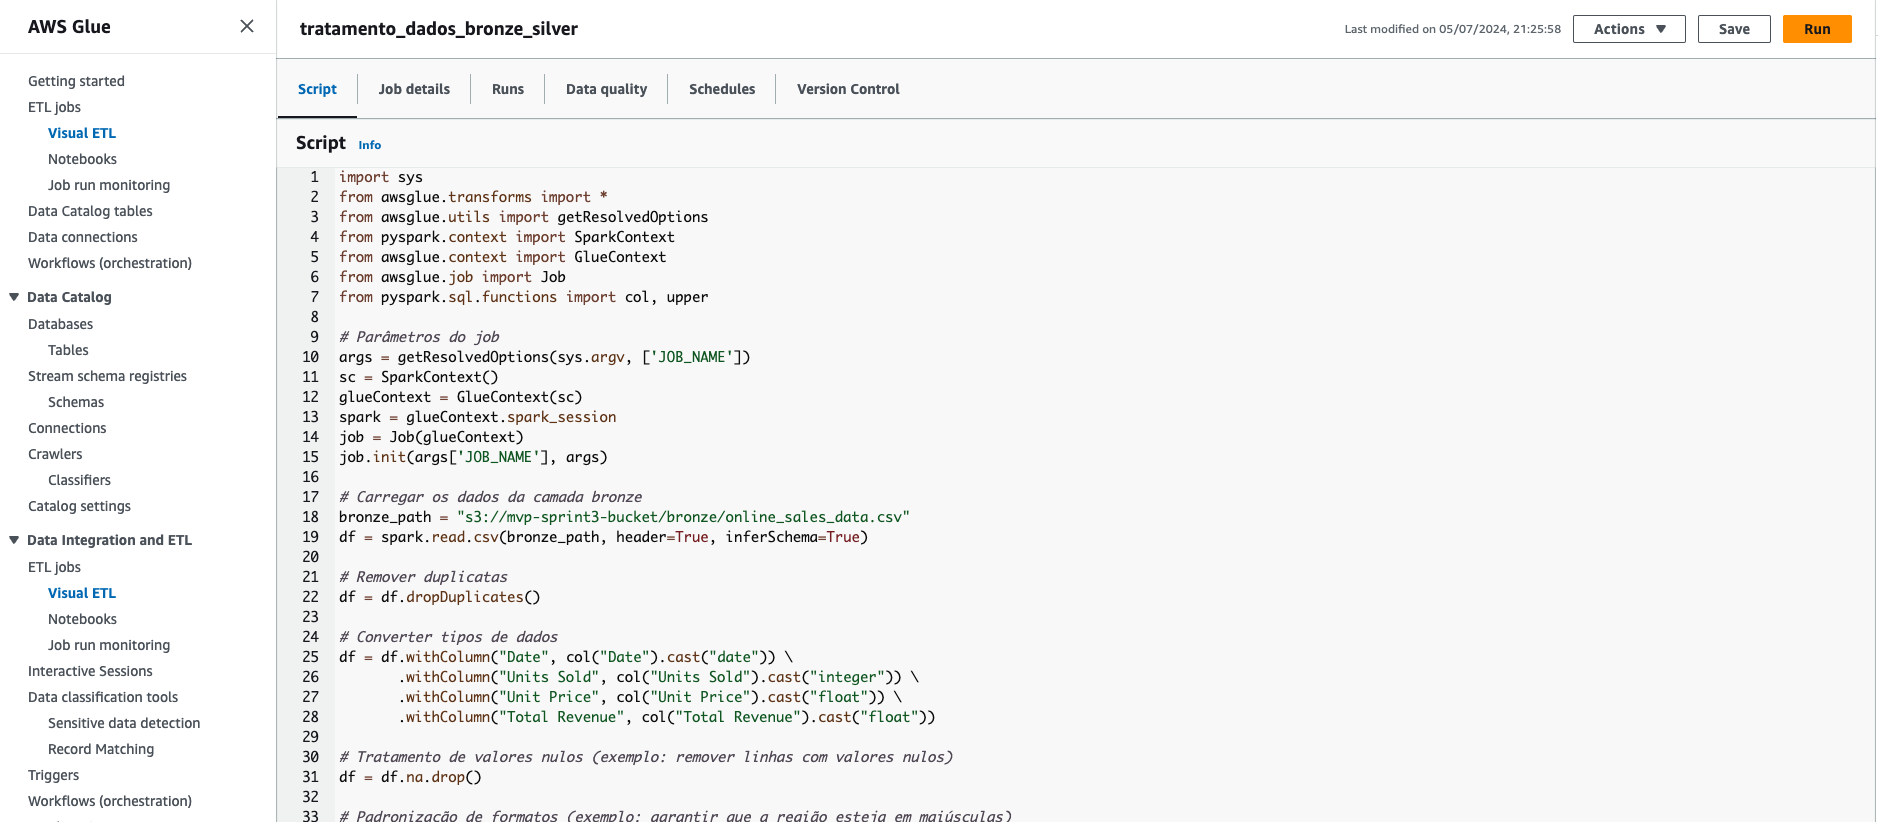

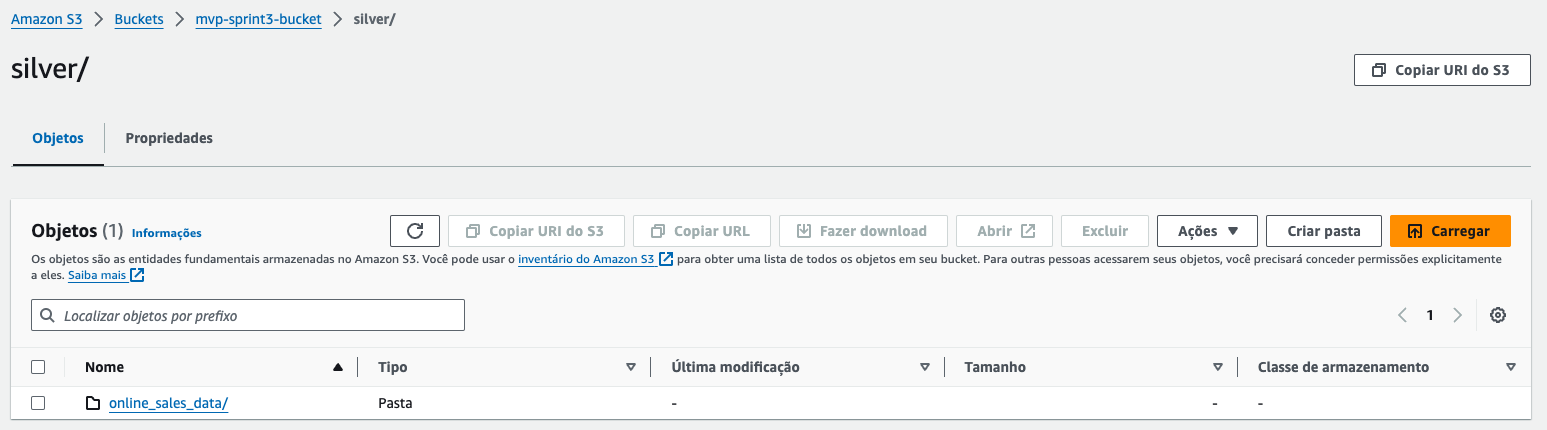

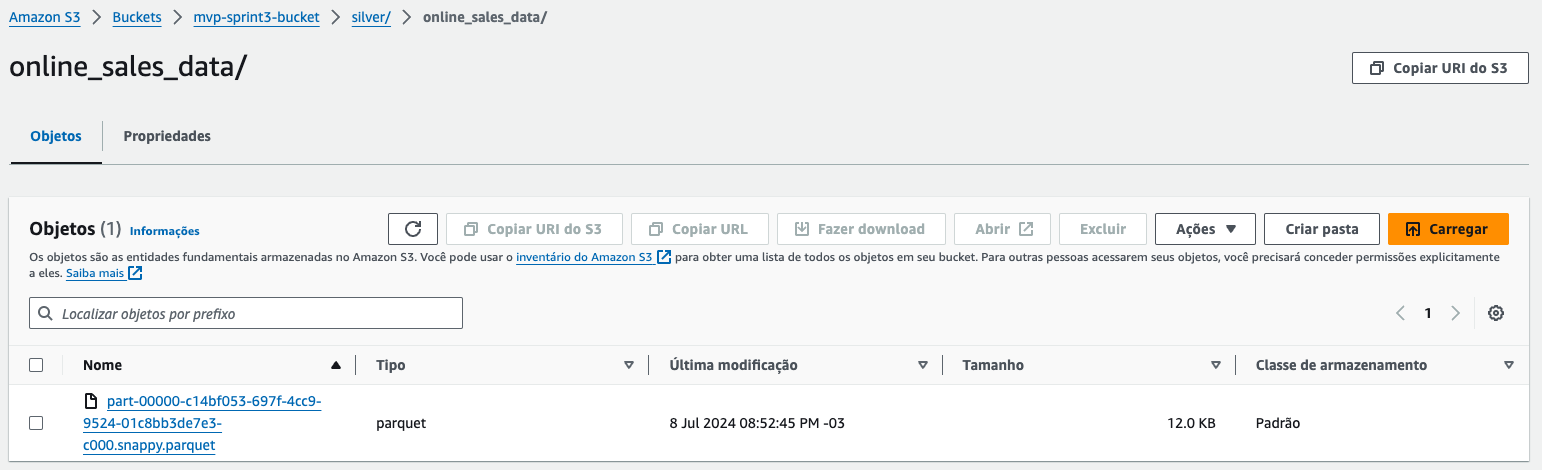

#**Passo 3 - Refinamento dos dados (Camada Gold)**

Neste código para a camada Gold, estou executando uma série de operações fundamentais para agregar valor aos dados já tratados na camada Silver:

- Contexto e Parâmetros: Inicio o script configurando o contexto do Spark e do Glue, além de inicializar o job com os parâmetros fornecidos.

- Definição de Banco de Dados e Tabelas: Especifico o nome do banco de dados (data_lake_mvp) e os nomes das tabelas de origem (silver_online_sales_data) e destino (gold_online_sales_data).

- Carregamento e Conversão de Dados: Carrego os dados da tabela da camada Silver utilizando o AWS Glue DynamicFrame e converto para um DataFrame do Spark para facilitar manipulações subsequentes. É importante verificar o esquema dos dados para garantir que os nomes das colunas estejam corretos e consistentes.

- Aplicação de Transformações: Aplico transformações nos dados conforme necessário. Um exemplo dado é o cálculo da média de "Total Revenue" por categoria de produto (Product Category). Isso permite analisar o desempenho médio de vendas por categoria.

- Persistência na Camada Gold: Salvo o DataFrame resultante na camada Gold do Amazon S3, utilizando o formato Parquet. Este formato é ideal para armazenamento eficiente e consulta posterior, preservando a estrutura dos dados e facilitando análises complexas.

- Commit do Job: Finalmente, realizo o commit do job do Glue para garantir que todas as operações sejam concluídas de forma consistente e que os dados sejam persistidos de acordo com as especificações definidas.

Essas etapas são cruciais para transformar dados tratados na camada Silver em insights valiosos na camada Gold, preparando-os para análises mais avançadas e suportando decisões estratégicas dentro da organização.








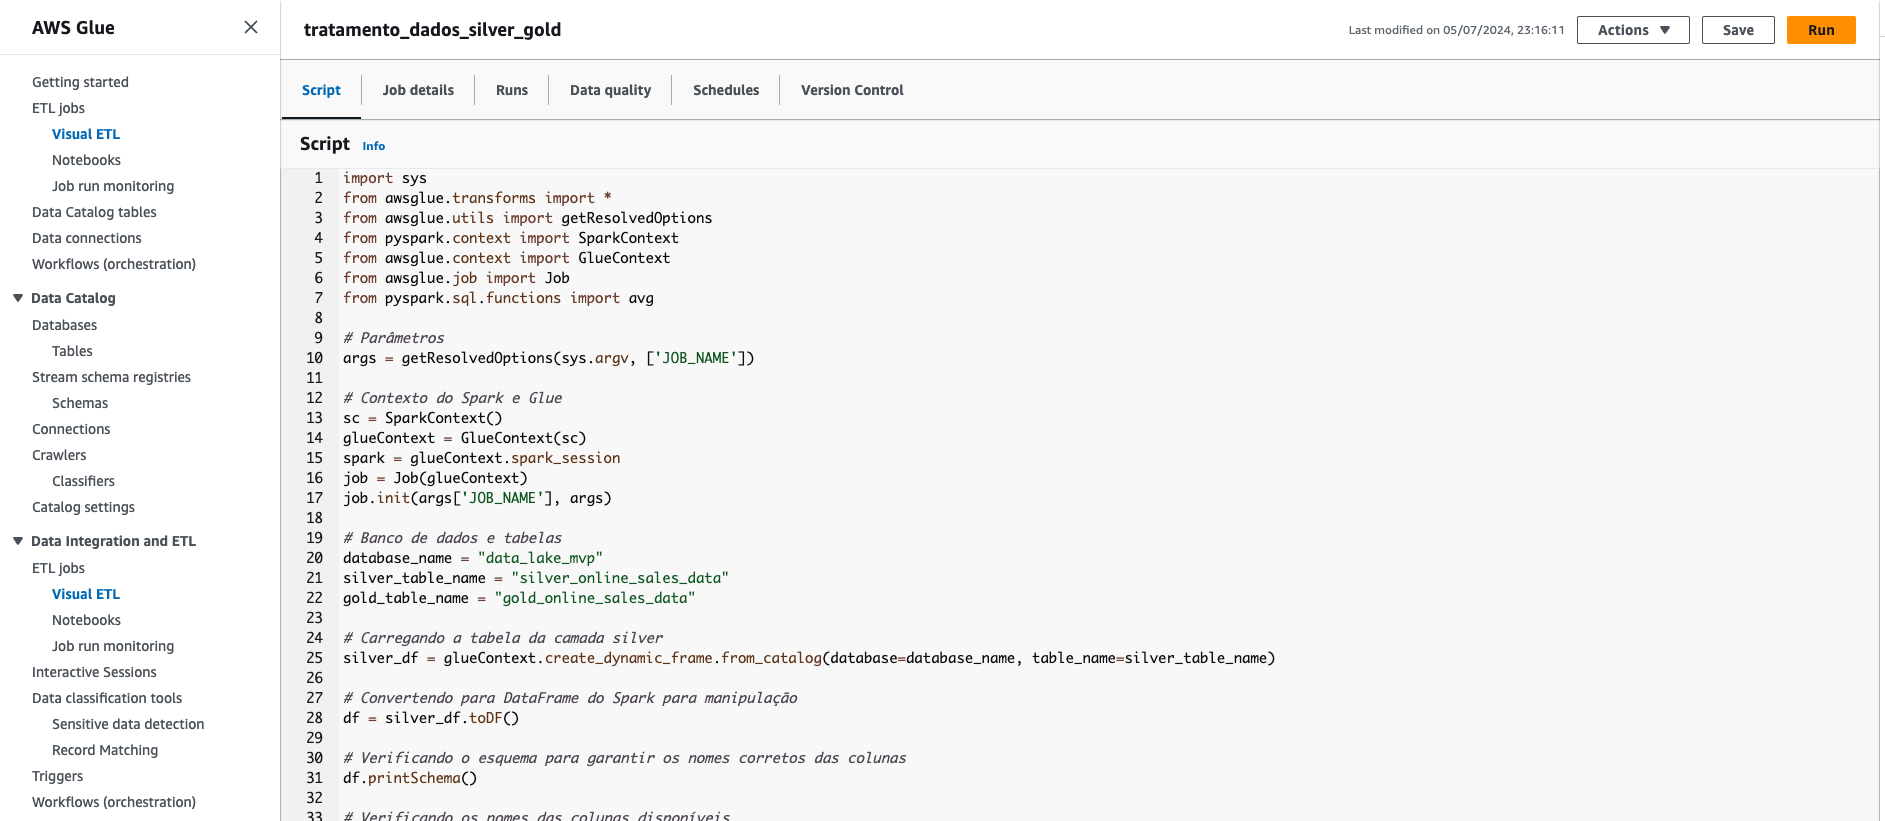

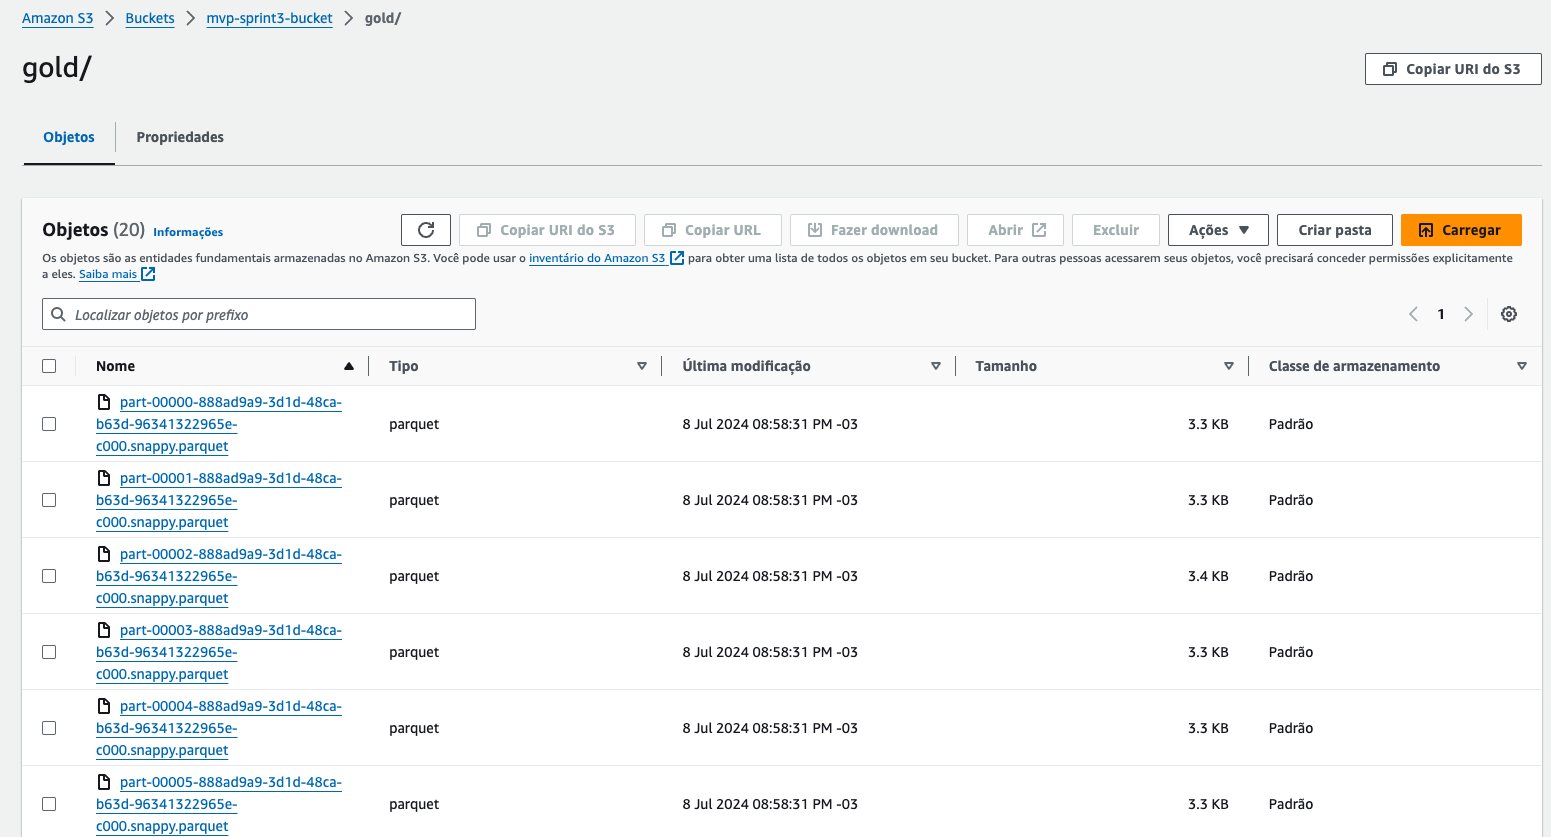

#**Passo 4 - Orquestração da Pipeline de Dados**

Utilizando o AWS Glue Workflows, a pipeline de dados foi estruturada da seguinte forma:

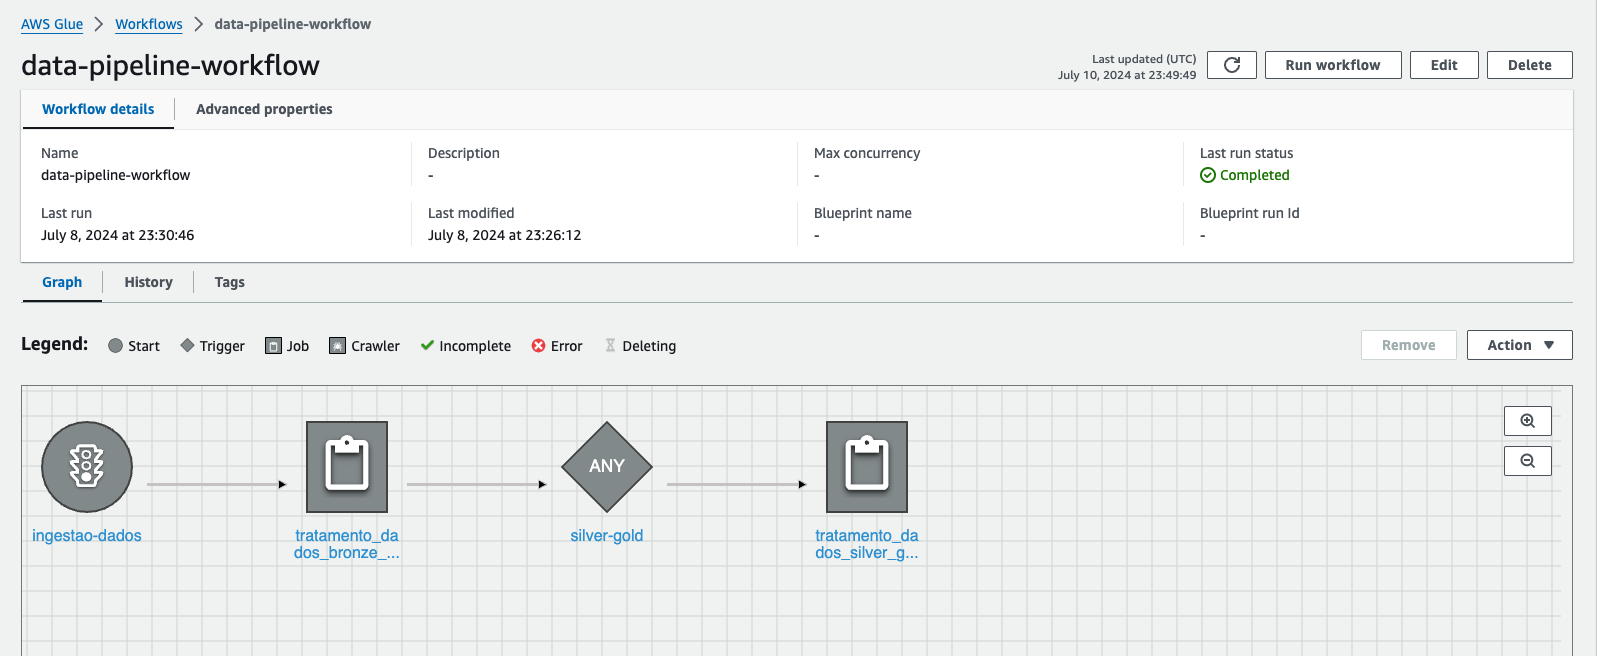

#**Passo 5 - Catalogando os dados**

O processo de catalogação dos dados é realizado por meio do componente AWS Glue Crawlers.

Nesse processos, os dados da camada Gold são catalogados e disponibilizandos em um banco de dados que foi denominado data-goldgold, para posteriormente ser analisado na camada de visualização.

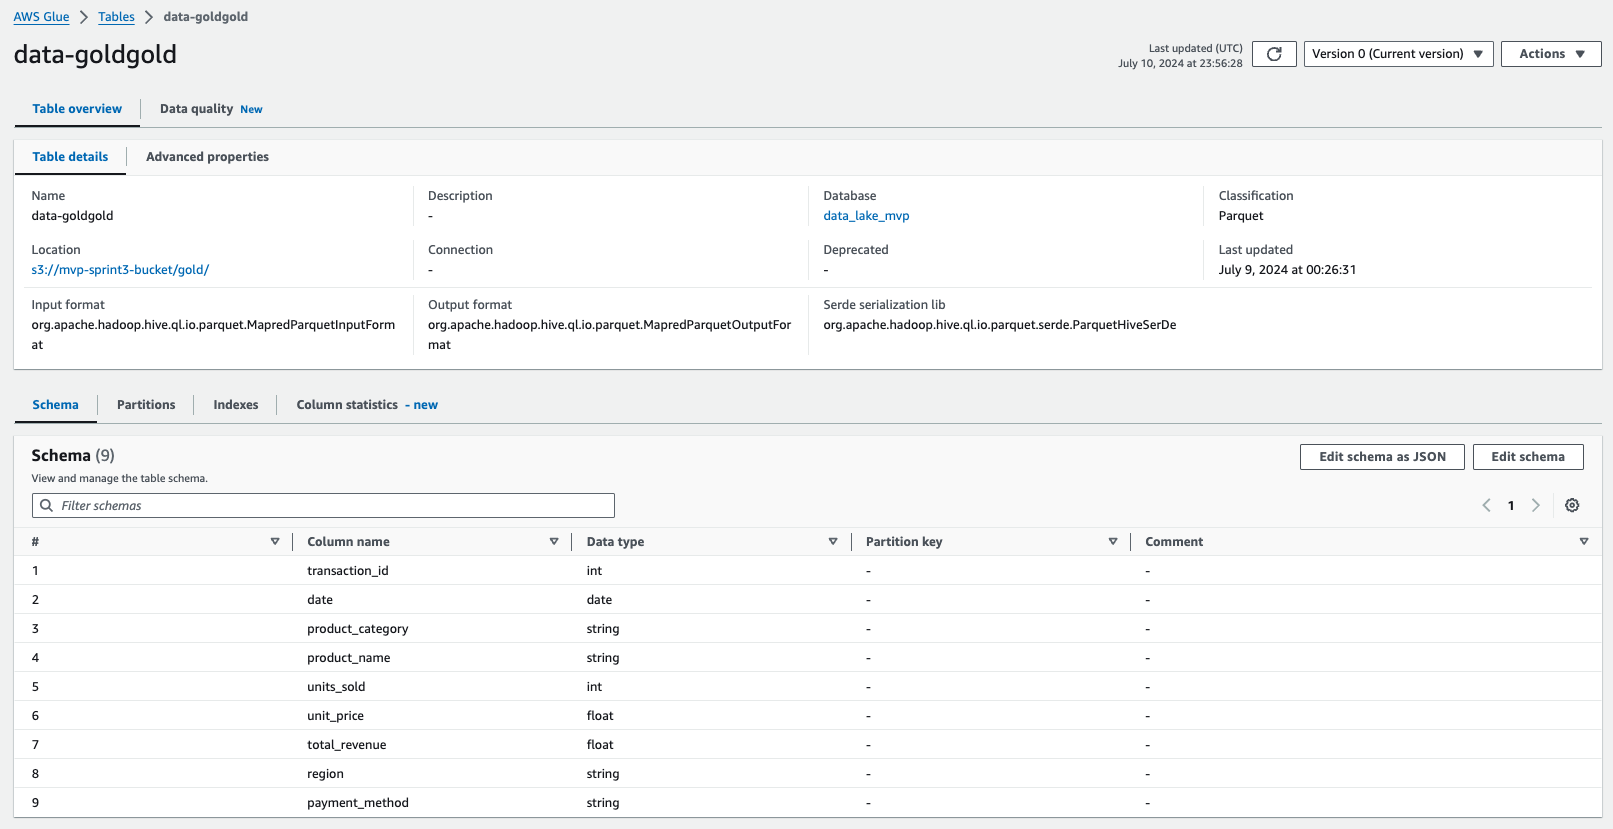

#**Passo 6 - Teste da Análise dos Dados**

Inicialmente, foi realizado um teste de consulta aos dados catalogados por meio da ferramenta AWS Athena:

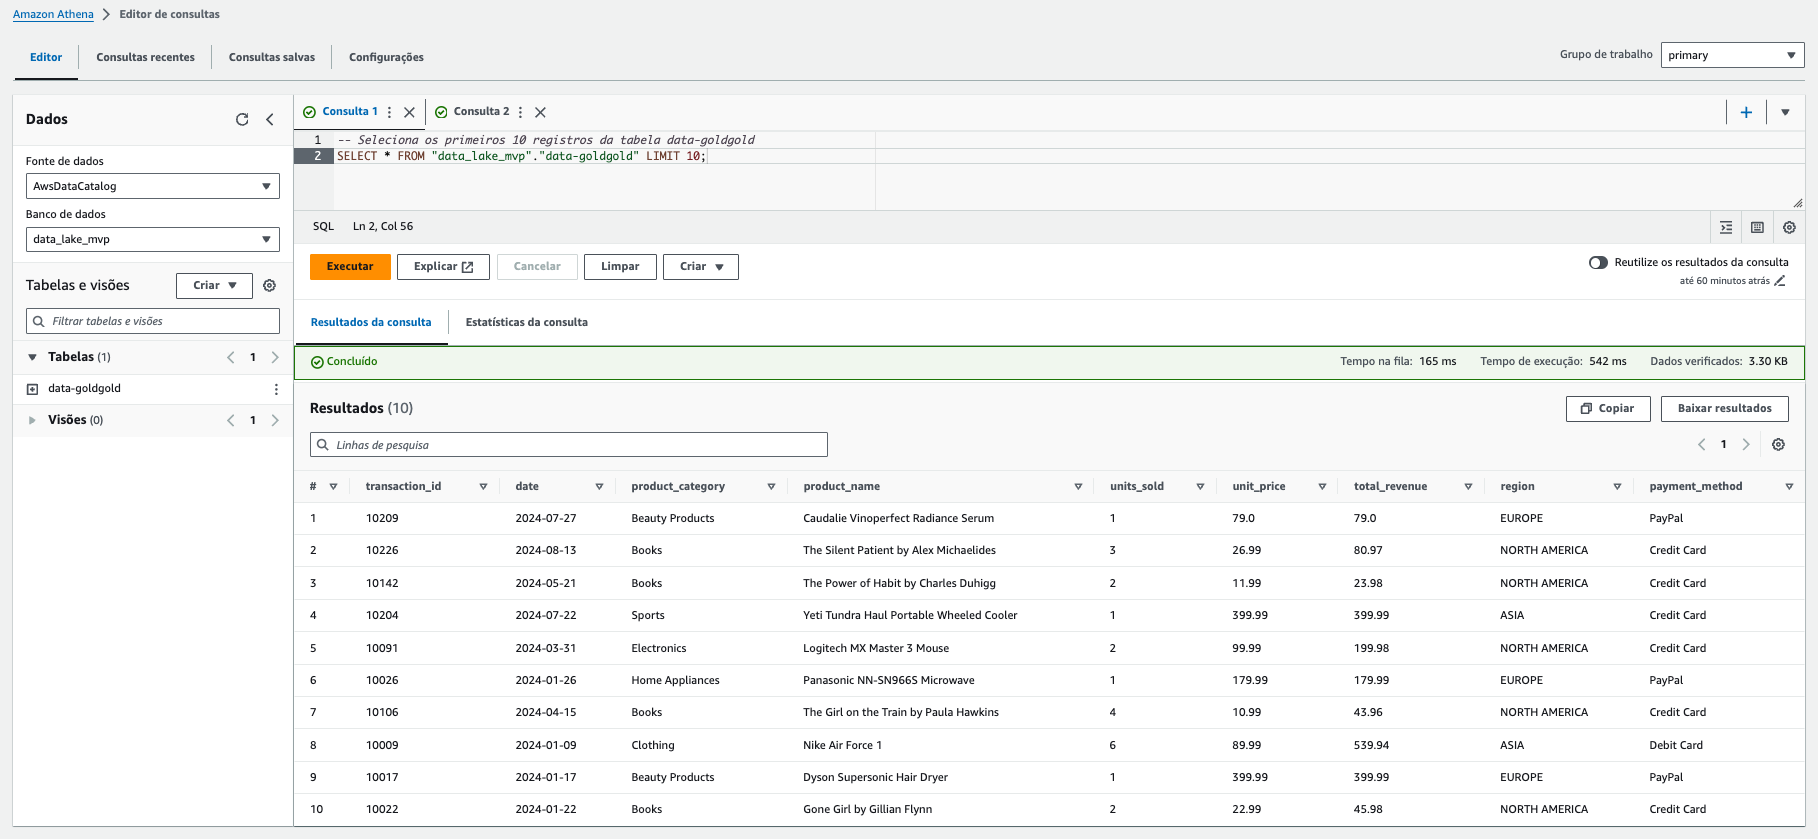

Neste código, realizei a consulta dos 10 primeiros registros da base de dados, a fim de demonstrar que a conexão está funcionando de forma adequada.

#**Passo 7 - Análise dos Dados**

Nessa etapa, foi realizada uma análise sobre a qualidade dos dados.

Seguindo a sugestão do MVP, foram feitas as seguintes verificações sobre o conjunto de dados:


###Verificação de valores nulos


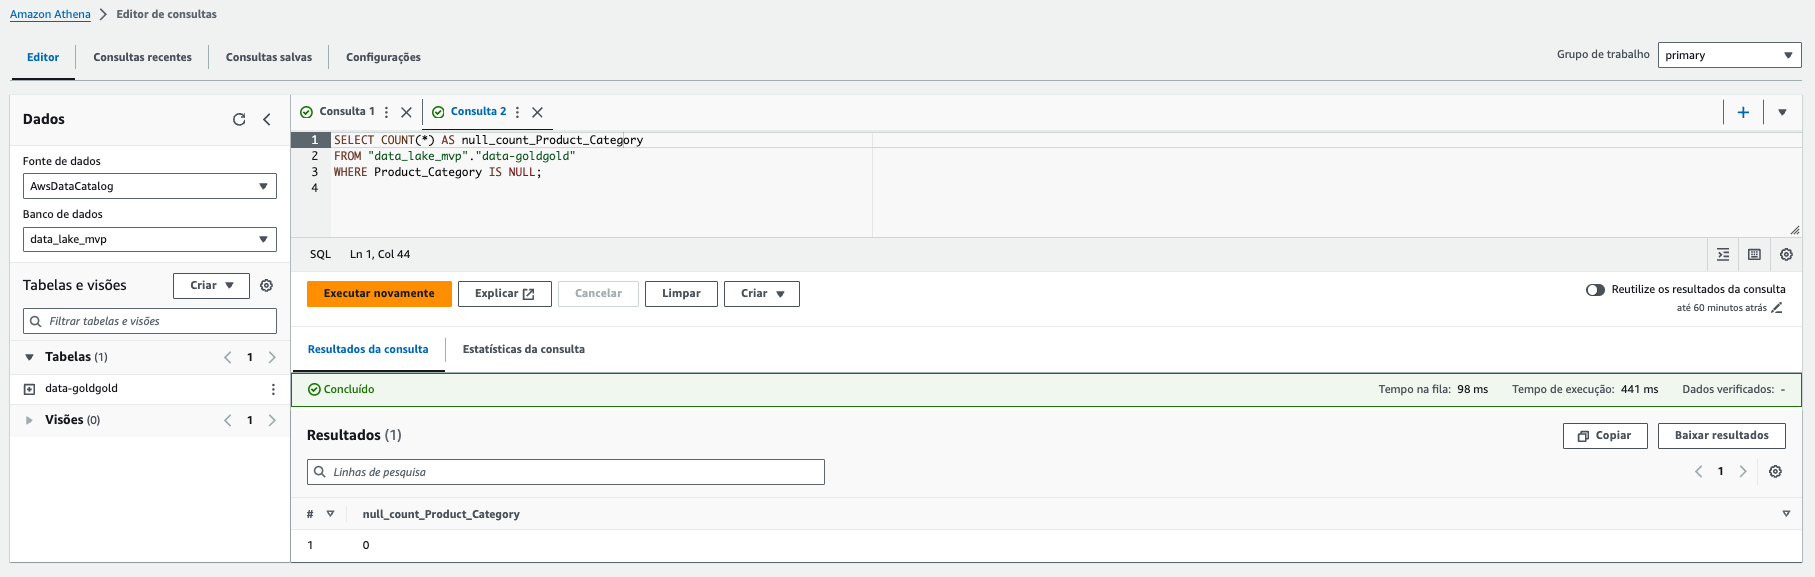

Não foram identificados valores nulos.

###Contagem de registros duplicados

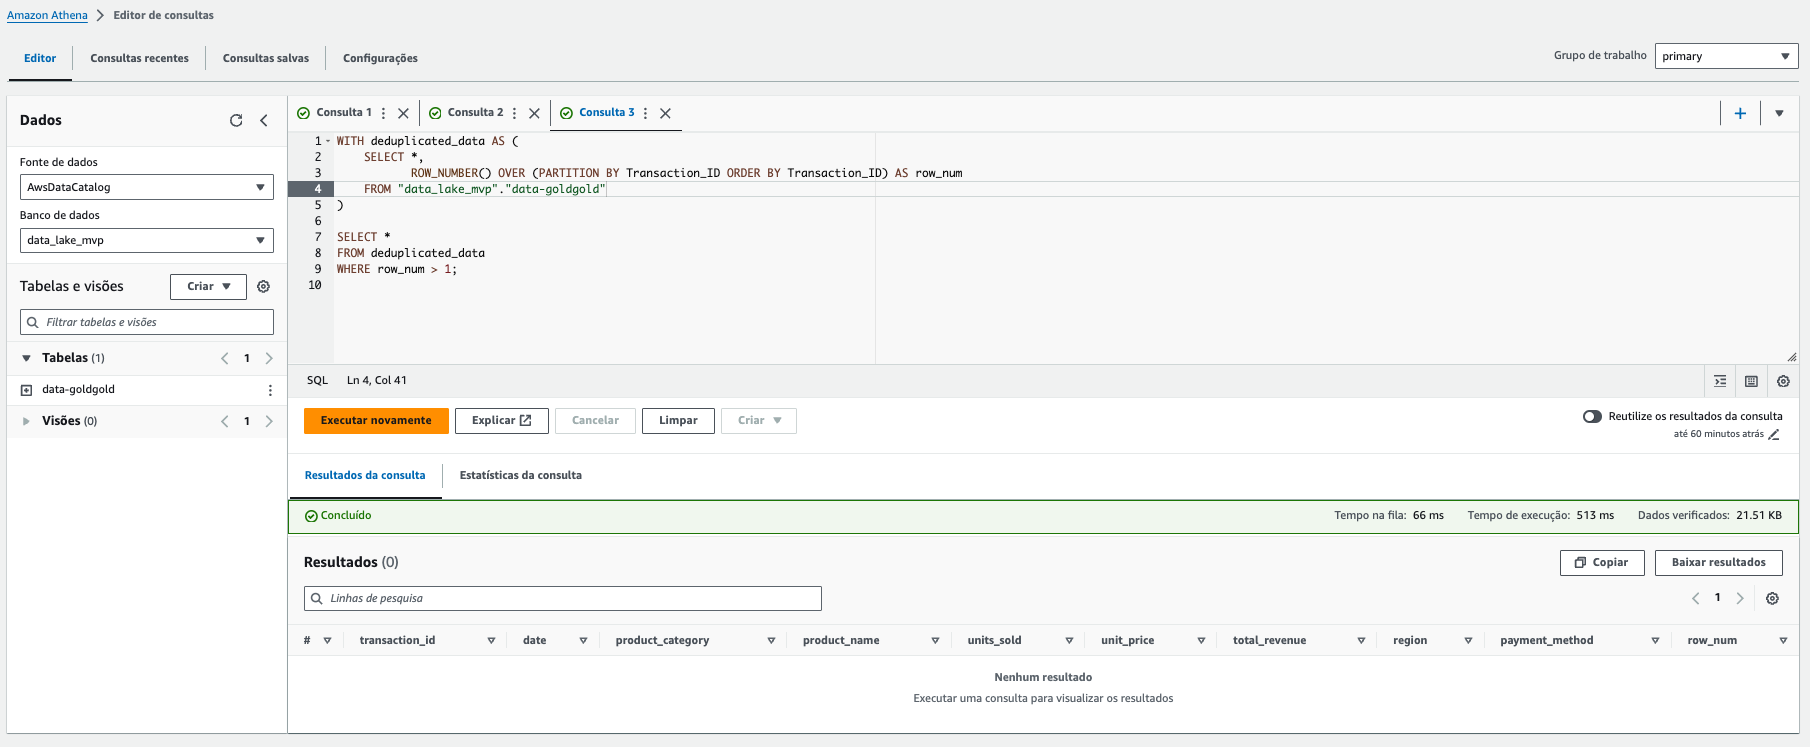

Nenhum registro duplicado.

###Cálculo de estatísticas descritivas

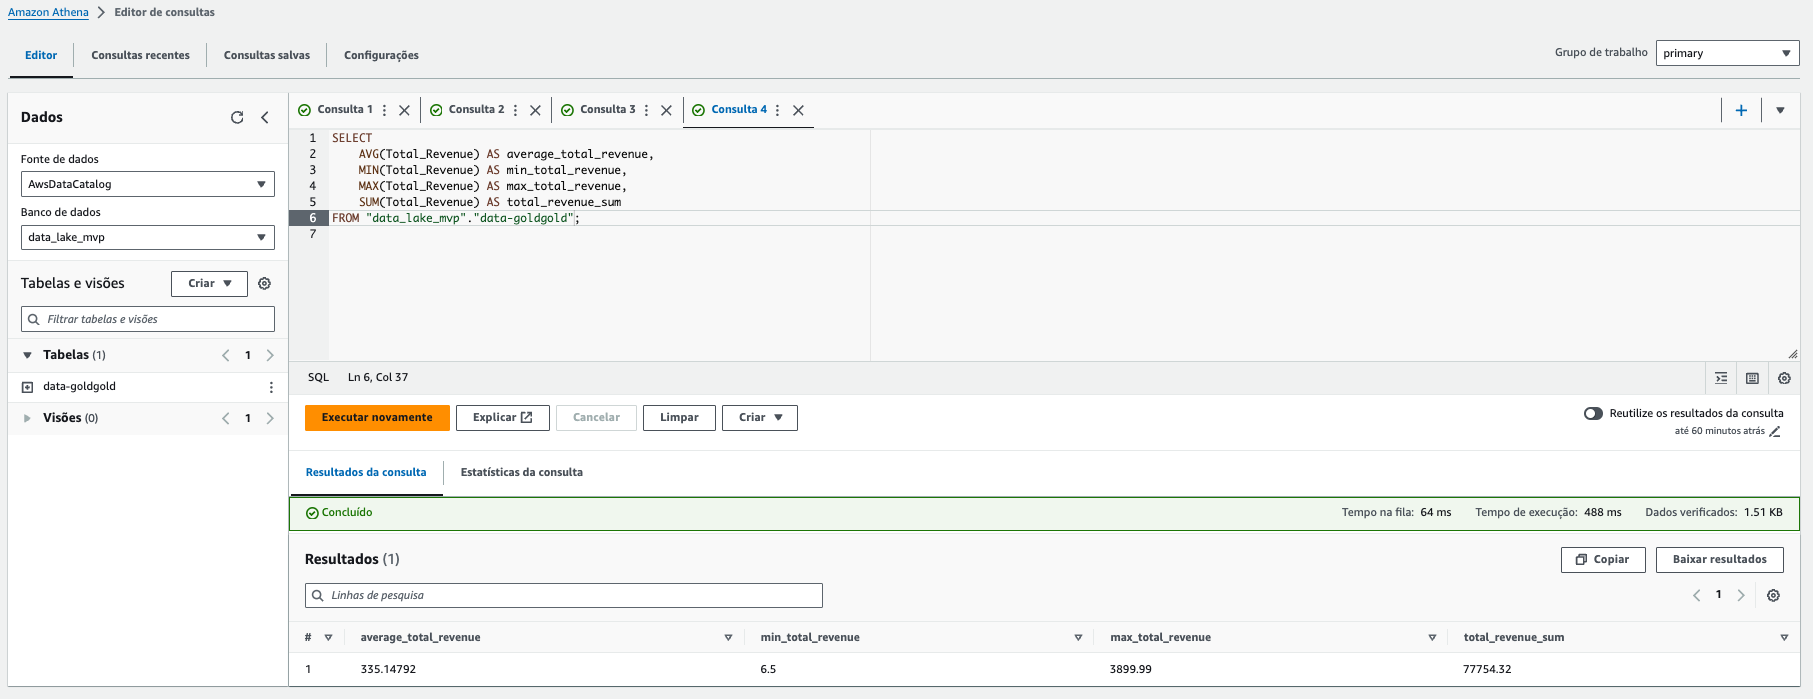

#**Passo 8 - Resolução dos Problemas**

Os dois problemas que motivaram esse trabalho foram:

1 - Qual é o impacto dos métodos de pagamento no volume de vendas e na receita?

2 - Quais são os produtos mais vendidos em cada categoria e como eles contribuem para a receita total da categoria?

###1. Impacto dos métodos de pagamento no volume de vendas e na receita


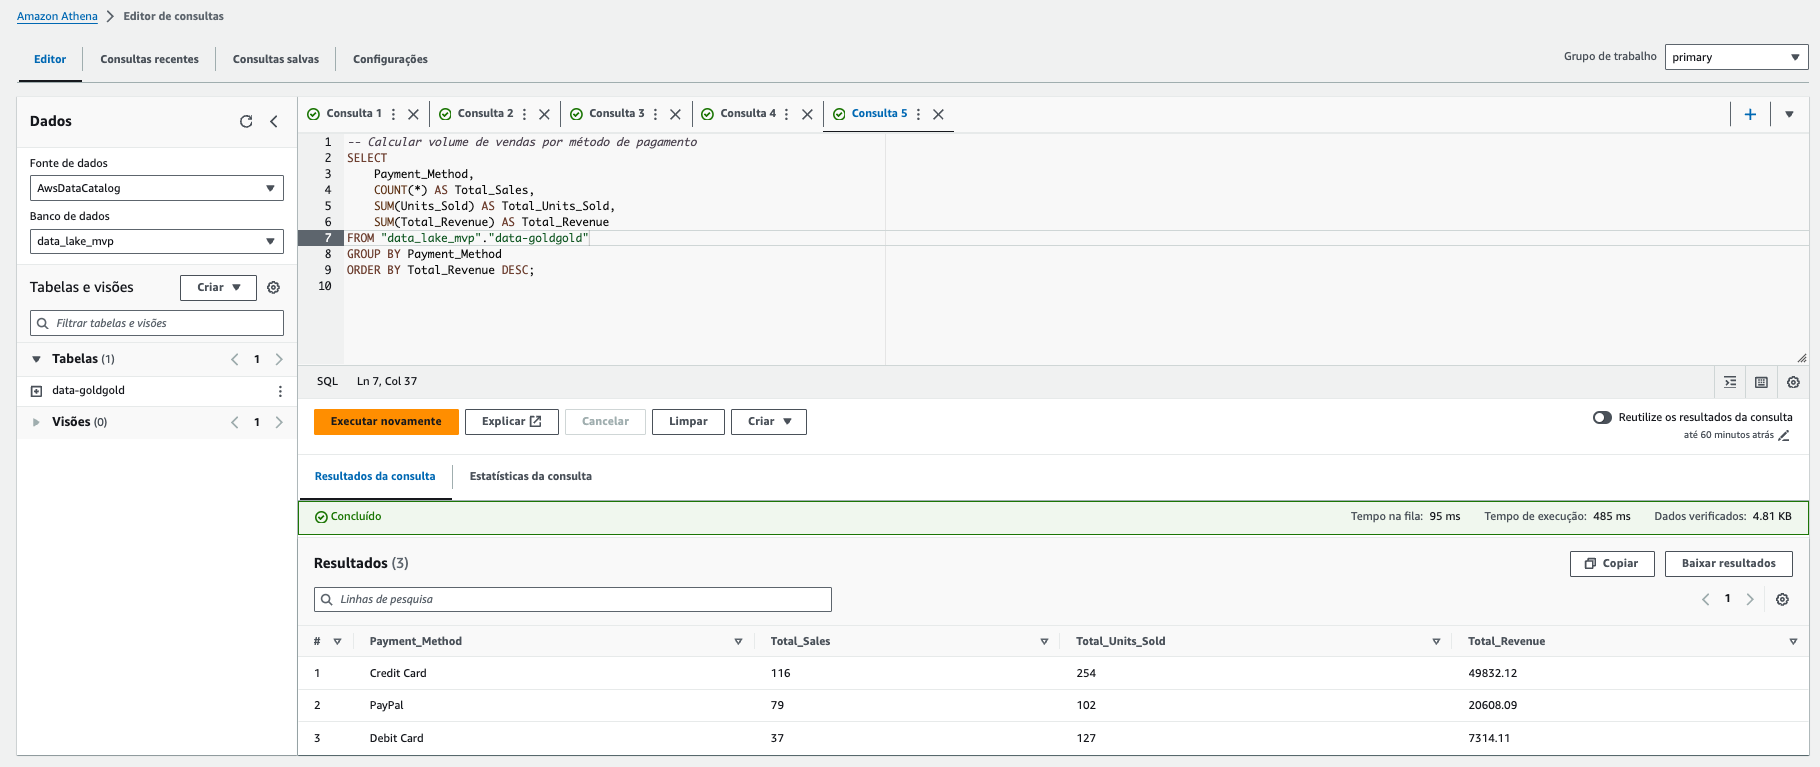

Com base no resultado dessa consulta, podemos obter os seguintes insigths:

- Credit Card: Como este método lidera em número de transações, unidades vendidas e receita gerada, uma sugestão seria investir em programas de fidelidade específicos para clientes que utilizam cartão de crédito, oferecendo pontos extras, descontos exclusivos ou promoções especiais para aumentar ainda mais o engajamento e as vendas.

- PayPal: Para os clientes que preferem PayPal, uma ação estratégica seria explorar parcerias ou promoções que incentivem o uso desse método de pagamento, como cashbacks ou descontos progressivos em compras recorrentes, para atrair mais clientes e aumentar o volume de vendas.

- Debit Card: Dado o menor impacto em termos de transações e receita, seria recomendável implementar campanhas específicas para incentivar o uso de débito, como descontos instantâneos em compras acima de um determinado valor ou participação em sorteios exclusivos para clientes que pagam com débito.

Essas ações visam não apenas otimizar o uso de cada método de pagamento, mas também aumentar o volume de vendas e a receita total, alinhando-se às preferências e comportamentos dos clientes identificados nos dados.

###2. Produtos mais vendidos em cada categoria e sua contribuição para a receita


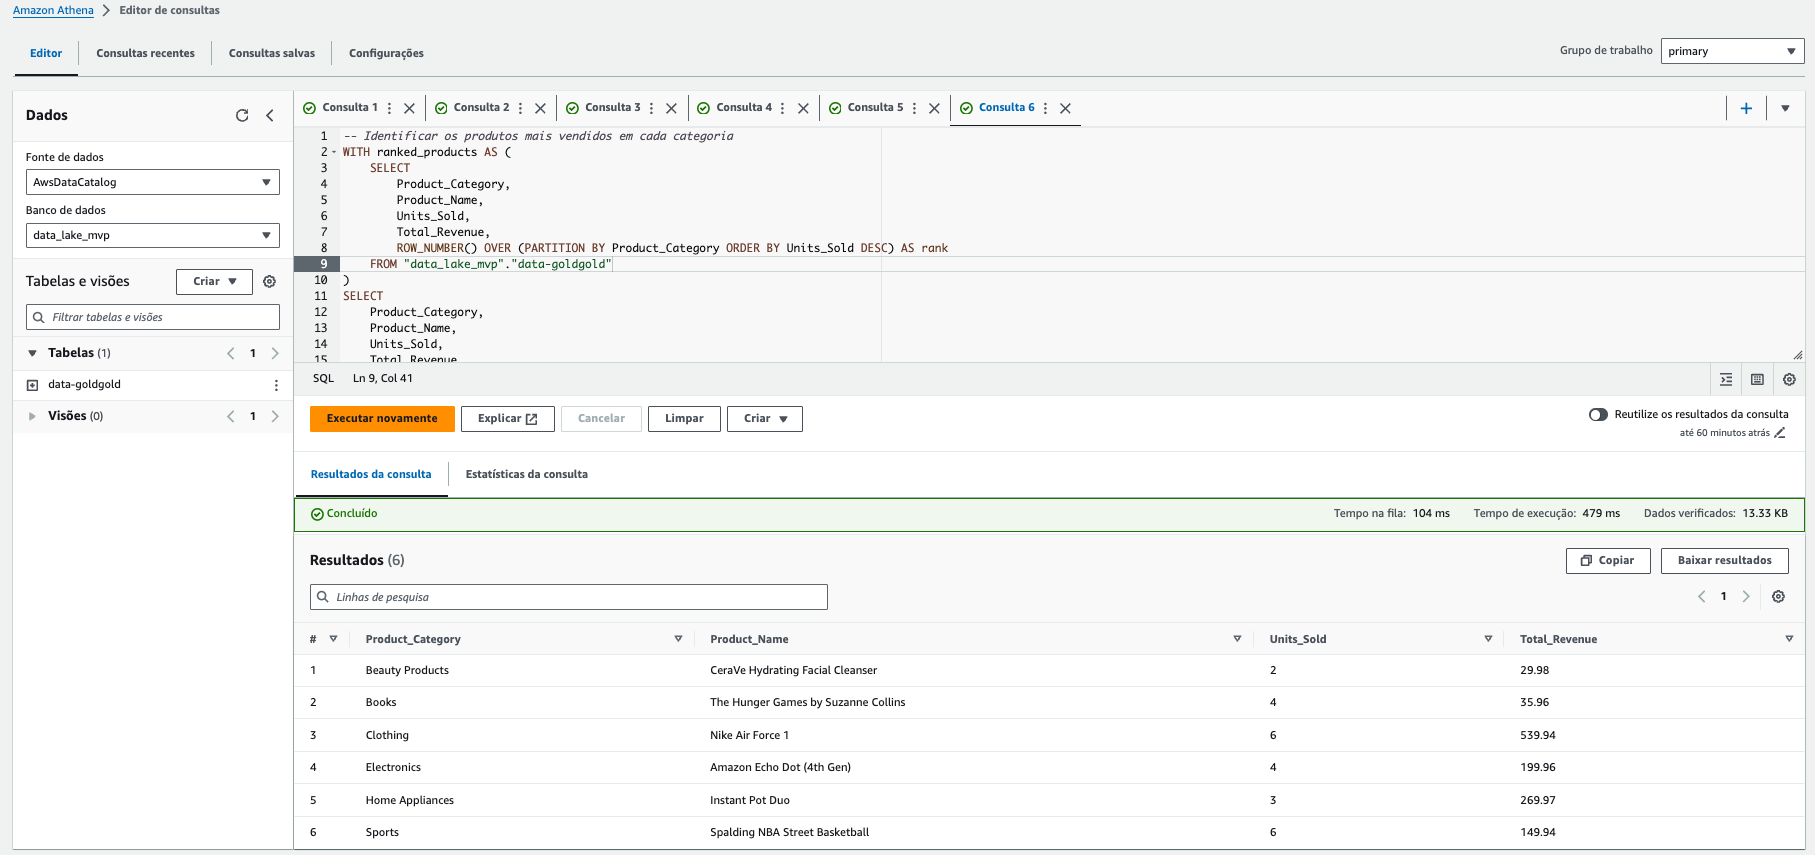

Com base na interpretação dos produtos mais vendidos em cada categoria e sua contribuição para a receita total, aqui estão algumas sugestões de ação:

- Beauty Products (Produtos de Beleza): Investir em campanhas promocionais ou bundles com o CeraVe Hydrating Facial Cleanser para aumentar a visibilidade e impulsionar as vendas deste produto, aproveitando sua popularidade.

- Books (Livros): Expandir o estoque de best-sellers como "The Hunger Games" e considerar a promoção de outros livros populares para atrair mais clientes e aumentar as vendas nessa categoria.

- Clothing (Roupas): Avaliar a disponibilidade do Nike Air Force 1 para garantir que a demanda seja atendida, considerando também a introdução de novos modelos ou cores populares para diversificar o mix de produtos.

- Electronics (Eletrônicos): Promover o Amazon Echo Dot (4th Gen) com ofertas especiais ou bundles com outros dispositivos inteligentes para incentivar compras adicionais e aumentar a receita nesta categoria.

- Home Appliances (Eletrodomésticos): Explorar oportunidades para destacar o Instant Pot Duo em campanhas sazonais ou de culinária, ressaltando seus benefícios e versatilidade para atrair mais consumidores interessados em eletrodomésticos.

- Sports (Esportes): Considerar parcerias com influenciadores esportivos ou lançar promoções que destacam a qualidade e durabilidade da bola de basquete Spalding NBA Street para aumentar as vendas, especialmente durante temporadas esportivas populares.

Essas ações visam capitalizar nos produtos mais vendidos de cada categoria, otimizando estratégias de marketing e estoque para impulsionar ainda mais as vendas e a receita.










#Passo 9 - Autoavaliação

O objetivo foi alcançado, pois consegui realizar todas as etapas da pipeline de dados, desde a coleta, modelagem, tratamento dos dados até a visualização e análise dos dados.

Minhas dificuldades giraram em torno de entender o funcionamento das ferramentas da AWS. No entanto, após entender a lógica da plataforma, o trabalho fluiu e foi concluído com sucesso.